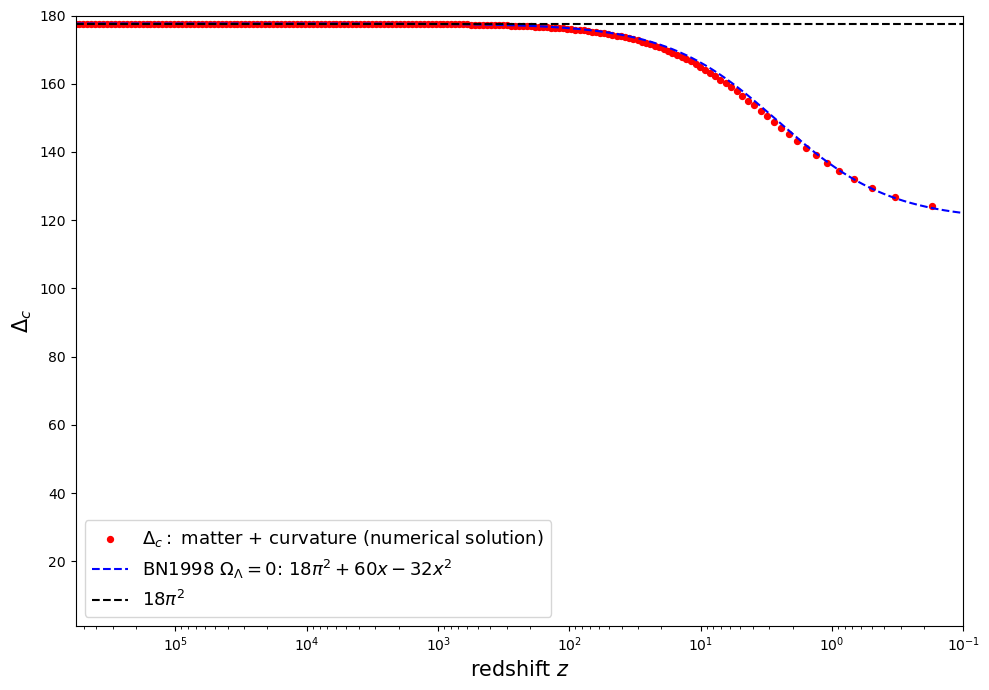

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from math import sqrt


# Background cosmology: matter + curvature (no Λ)

G = 1.0
Omega_m0 = 0.3
Omega_k0 = 1.0 - Omega_m0
H0 = 1.0

# Present-day critical density and component densities
rho_crit0 = 3*H0**2 / (8*np.pi*G)
rho_m0 = Omega_m0 * rho_crit0
rho_k0 = Omega_k0 * rho_crit0

def rhs_bg(t, y):
    """
    System:
        - y = [a, rho_m, rho_k]
        - da/dt      = a H(a)
        - d(rho_m)/dt = -3 H rho_m   
        - d(rho_k)/dt = -2 H rho_k   
    Returns: [da_dt, drho_m_dt, drho_k_dt]
    """
    a, rho_m, rho_k = y
    a = max(a, 1e-40)
    rho_m = max(rho_m, 0.0)
    rho_k = max(rho_k, 0.0)
    rho_tot = rho_m + rho_k
    H2 = (8.0 * np.pi * G / 3.0) * max(rho_tot, 0.0)
    H  = sqrt(H2)
    return [a*H, -3*H*rho_m, -2.*H*rho_k]

# Integrate background from very early scale factor 
a_init = 1e-8
y0_bg  = [a_init, rho_m0 * a_init**-3, rho_k0*a_init**-2]
t0, tf = 0.0, 8.0e4

# Radau is used because the system can behave stiffly at early times.
sol_bg = solve_ivp(rhs_bg, (t0, tf), y0_bg, method='Radau', rtol=1e-10, atol=1e-12, dense_output=True)

t      = sol_bg.t
a      = sol_bg.y[0]
rho_m  = sol_bg.y[1]
rho_k  = sol_bg.y[2]

rho_tot = rho_m + rho_k
H       = np.sqrt((8.0 * np.pi * G / 3.0) * rho_tot)
rho_c   = 3.0 * H**2 / (8.0 * np.pi * G)


# Interpolators for background quantities
a_of_t = interp1d(t, a, kind='cubic', bounds_error=False, fill_value='extrapolate')
t_of_a = interp1d(a, t, kind='cubic', bounds_error=False, fill_value='extrapolate')
H_of_t = interp1d(t, H,kind='cubic', bounds_error=False, fill_value='extrapolate')
rho_m_of_t = interp1d(t,rho_m, kind='cubic', bounds_error=False, fill_value='extrapolate')
rho_c_of_t = interp1d(t,rho_c, kind='cubic', bounds_error=False, fill_value='extrapolate')


def rhs_tophat(t, y, M):
    """
    Spherical top-hat equation of motion with constant mass.
        y = [R, V]
        R = radius
        V = dR/dt
        d^2R/dt^2 = -GM/R^2
    Notes:
    - R is bounded below to avoid dividing by zero
    Returns: [dR_dt, dV_dt]
    """
    R, V = y
    R = max(R, 1e-40)
    return [V, -G*M/(R**2)]


# Choose ICs:
i0       = 10
t_i      = t[i0]
a_i      = float(a_of_t(t_i))
H_i      = float(H_of_t(t_i))
rho_m_i  = float(rho_m_of_t(t_i))

# Initial overdensity grid to go over:
# Larger grid = better resolution but more to solve, it takes longer.
delta_grid = np.logspace(-8, -2, 200)

# Arrays to fill up:
# zvir_list: virialization redshift based on a_vir
# delta_crit_ratio_list: rho_tophat / rho_crit at virialization
zvir_list = []
delta_crit_ratio_list = []  #ρ_tophat/ρ_crit at virialization

# Iterate over each possible d0:
for d0 in delta_grid:
    # Linear initial conditions for spherical overdensity:
    # R_i = a_i r_com (1 - δ/3)
    # V_i = H_i R_i (1 - δ/3)
    r_com = 1.0
    R_i = a_i * r_com * (1.0 - d0/3.0)
    V_i = H_i * R_i * (1.0 - d0/3.0)

    M   = (4.0/3.0) * np.pi * (R_i**3) * rho_m_i * (1.0 + d0)

    # Define turnaround event: V = 0 while transitioning from expansion (V>0) to collapse (V<0).
    def ev_turn(tt, yy):
        return yy[1]
    ev_turn.terminal  = True
    ev_turn.direction = -1

    # Integrate until turnaround is reached (or until tf).
    sol1 = solve_ivp(lambda tt, yy: rhs_tophat(tt, yy, M), (t_i, tf), [R_i, V_i], method='Radau',
        rtol=1e-10, atol=1e-12, dense_output=True, events=ev_turn)

    if len(sol1.t_events[0]) == 0:
        # Turnaround not reached within the integration window; skip this d0.
        continue

    # t_vir = 2 t_turn, R_vir = R_turn / 2
    # this is an assumption; change if using different virializtaion criteria
    t_max = sol1.t_events[0][0]
    R_max = sol1.sol(t_max)[0]
    t_vir = 2.0 * t_max
    R_vir = 0.5 * R_max

    # Make sure the background interpolation range includes t_vir.
    if not (t[0] <= t_vir <= t[-1]):
        continue

    # Densities at virialization:
    # rho_th_vir: mean density inside the top-hat sphere at R_vir
    # rho_c_vir: background critical density at t_vir
    rho_th_vir = (3.0*M)/(4*np.pi*R_vir**3)  #tophat density
    rho_c_vir  = float(rho_c_of_t(t_vir))              #crit density

    a_vir = float(a_of_t(t_vir))
    z_vir = 1.0 / a_vir - 1.0

    zvir_list.append(z_vir)
    delta_crit_ratio_list.append(rho_th_vir / rho_c_vir)

zvir  = np.array(zvir_list)
Delta_crit_ratio_num = np.array(delta_crit_ratio_list)


# Get Bryan & Norman (1998) (BN) approximation for overdensity in m+k universe.
Om = rho_m/rho_c
x  = Om - 1.0
f = 18.0 * np.pi**2 + 60.0 * x - 32.0 * x**2

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(zvir, Delta_crit_ratio_num,color='r', s=18,
           label=r'$\Delta_{c}:$ matter + curvature (numerical solution)')
ax.plot(1.0/a - 1, f, color='b',linestyle='--',
        label=r'BN1998 $\Omega_{\Lambda}=0$: $18\pi^{2}+60x-32x^{2}$')
ax.set_xscale('log')
ax.invert_xaxis()
ax.set_ylim(1,180)
ax.set_xlim(np.max(zvir)+100,1e-1)
ax.set_xlabel('redshift $z$', fontsize=15)
ax.set_ylabel(r'$\Delta_{c}$', fontsize=15)
# Additional Reference: EdS overdensity = 18π^2.
plt.axhline(y=18*np.pi**2,color='k', linestyle='--',label=r'$18\pi^{2}$')
ax.legend(loc='best',fontsize=13)
plt.tight_layout()
plt.show()